In [ ]:
from machine import Pin, PWM, time_pulse_us
import time

# for disturbance and outlier rejection
class Filtered:

    def __init__(self, threshold = 10, persistance = 3):

        self.threshold = threshold
        self.persistance = persistance
        self.last = None
        self.pending = None
        self.count = 0
        self.values = []
        self.raw = []

    def filter(self, value):

        self.raw.append(value)

        # base case:
        if self.last == None:

            self.last = value

        # edge case
        if value is None:
            return
        
        # the point is an outlier
        if abs(value - self.last) > self.threshold:

            # restart of the outlier is even bigger
            if self.pending is None or abs(value - self.pending) > self.threshold:
                self.pending = value
                self.count = 1
            
            # the outlier seems to be staying
            else:
                self.count += 1

            # the outlier has stayed long enough to be accepted
            if self.count >= self.persistance:
                self.last  = self.pending / 2 + self.last / 2
                self.pending = None
                self.count = 0

        # no outlier
        else:
            self.last = value / 2 + self.last / 2
            self.pending = None
            self.count = 0

        self.values.append(self.last)

    def __getitem__(self, key):
        return self.values[key]
        
TIMES = []
SETPOINTS = []
WINCH_DISTANCES = Filtered()
WALL_DISTANCES = Filtered()
WINCH_ACTIONS = []
SIDE_ACTIONS = []

# sensors
winch_sensor_trig = Pin(27, Pin.OUT)
winch_sensor_echo = Pin(26, Pin.IN)

wall_sensor_trig = Pin(12, Pin.OUT)
wall_sensor_echo = Pin(14, Pin.IN)

# motors
winch_motor_power = PWM(Pin(23), freq = 1000)
winch_motor_up = Pin(21, Pin.OUT)
winch_motor_down = Pin(22, Pin.OUT)

side_motor_power = Pin(5, Pin.OUT)
side_motor_north = Pin(18, Pin.OUT)
side_motor_south = Pin(19, Pin.OUT)

def test_sensors():

    # test winch sensor
    winch_distance = get_distance_cm(winch_sensor_trig, winch_sensor_echo)
    assert winch_distance is not None, "Winch sensor failed"
    
    time.sleep(1)

    # test wall sensor
    wall_distance = get_distance_cm(wall_sensor_trig, wall_sensor_echo)
    assert wall_distance is not None, "wall sensor failed"

def get_distance_cm(trig_pin: Pin, echo_pin: Pin, timeout_us=30000):

    # Send 10us trigger pulse
    trig_pin.value(0)
    time.sleep_us(2)
    trig_pin.value(1)
    time.sleep_us(10)
    trig_pin.value(0)

    pulse = time_pulse_us(echo_pin, 1, timeout_us)

    if pulse <= 0:
        return None
        return None

    return (pulse / 2) / 29.1  # cm

def winch_up(speed = 1023):
    winch_motor_down.off()
    winch_motor_power.duty(speed)
    winch_motor_up.on()

def winch_down(speed = 1023):
    winch_motor_up.off()
    winch_motor_power.duty(speed)
    winch_motor_down.on()

def winch_stop():
    winch_motor_power.duty(0)
    winch_motor_up.off()
    winch_motor_down.off()

def side_stop():
    side_motor_power.off()
    side_motor_north.off()
    side_motor_south.off()

def move_north():
    side_motor_south.off()
    side_motor_power.on()
    side_motor_north.on()

def sample(winch_distance, WALL_distance, setpoint = None, side_motor = 0):
    
    TIMES.append(time.ticks_ms())
    SETPOINTS.append(setpoint)
    WINCH_DISTANCES.filter(winch_distance)
    WALL_DISTANCES.filter(WALL_distance)
    SIDE_ACTIONS.append(side_motor)

def to_setpoint(setpoint):

    setpoint = max(10, min(setpoint, 50))

    while True:
        # wait a sec
        time.sleep(0.1)

        # record one sample per loop
        winch_distance = get_distance_cm(winch_sensor_trig, winch_sensor_echo)
        WALL_distance = get_distance_cm(wall_sensor_trig, wall_sensor_echo)
        
        sample(winch_distance, WALL_distance, setpoint)
        if winch_distance is not None and WALL_distance is not None:

            # P-only control
            error = setpoint - winch_distance
            K_c = 100
            actuator = K_c * error

            # mind the bounds
            actuator = int(min(1023, max(400, abs(actuator))))

            # timeout/no reading: stop motor and log action 0
            if winch_distance <= 0:
                winch_stop()
                WINCH_ACTIONS.append("0")
                # short delay then retry
                time.sleep(0.1)
                continue

            if error > 0.25:  # too far
                winch_up(actuator)
                WINCH_ACTIONS.append(str(actuator))

            elif error < -0.25:  # too close
                winch_down(actuator)
                WINCH_ACTIONS.append(str(actuator))

            else:  # at setpoint
                winch_stop()
                WINCH_ACTIONS.append("0")
                break

def pass_obstacle(setpoint, load_height = 7, threshold = 10):

    timer = 0
    found_obstacle = False
    
    while True:
        # wait a sec
        time.sleep(0.1)

        # measure distances
        winch_distance = get_distance_cm(winch_sensor_trig, winch_sensor_echo)
        WALL_distance = get_distance_cm(wall_sensor_trig, wall_sensor_echo)

        # there is a tall obstacle
        if winch_distance is not None and WALL_distance is not None:
            if WALL_distance + threshold + load_height < setpoint and not found_obstacle:
                found_obstacle = True
                sample(winch_distance, WALL_distance, None, 0)
                side_stop()
                to_setpoint(WALL_distance - load_height)

            # there is a valley / we passed over the obstacle
            if found_obstacle:
                timer += 1

            if timer > 80:
                sample(winch_distance, WALL_distance, None, 0)
                side_stop()

                # exit
                break

            # move forward
            else:
                sample(winch_distance, WALL_distance, None, 1)
                move_north()

def main():
    
    winch_stop()
    side_stop()
    test_sensors()

    try:
        # move_north()
        # time.sleep(1)
        side_stop()
        to_setpoint(45)
        pass_obstacle(45)
        to_setpoint(45)
        for _ in range(50):
            time.sleep(0.1)
            winch_distance = get_distance_cm(winch_sensor_trig, winch_sensor_echo)
            WALL_distance = get_distance_cm(wall_sensor_trig, wall_sensor_echo)
            sample(winch_distance, WALL_distance, None, 0)

    finally:

        with open("data.csv", "w") as file:
            file.write( "Time,Setpoint,Winch Distance,Wall Distance,Winch Action,Side Action\n")

            for thing in zip(TIMES, SETPOINTS, WINCH_DISTANCES.values, WALL_DISTANCES.values, WINCH_ACTIONS, SIDE_ACTIONS):

                file.write(",".join(map(str, thing)))
                file.write("\n")

if __name__ == "__main__":

    # alternate()
    main()


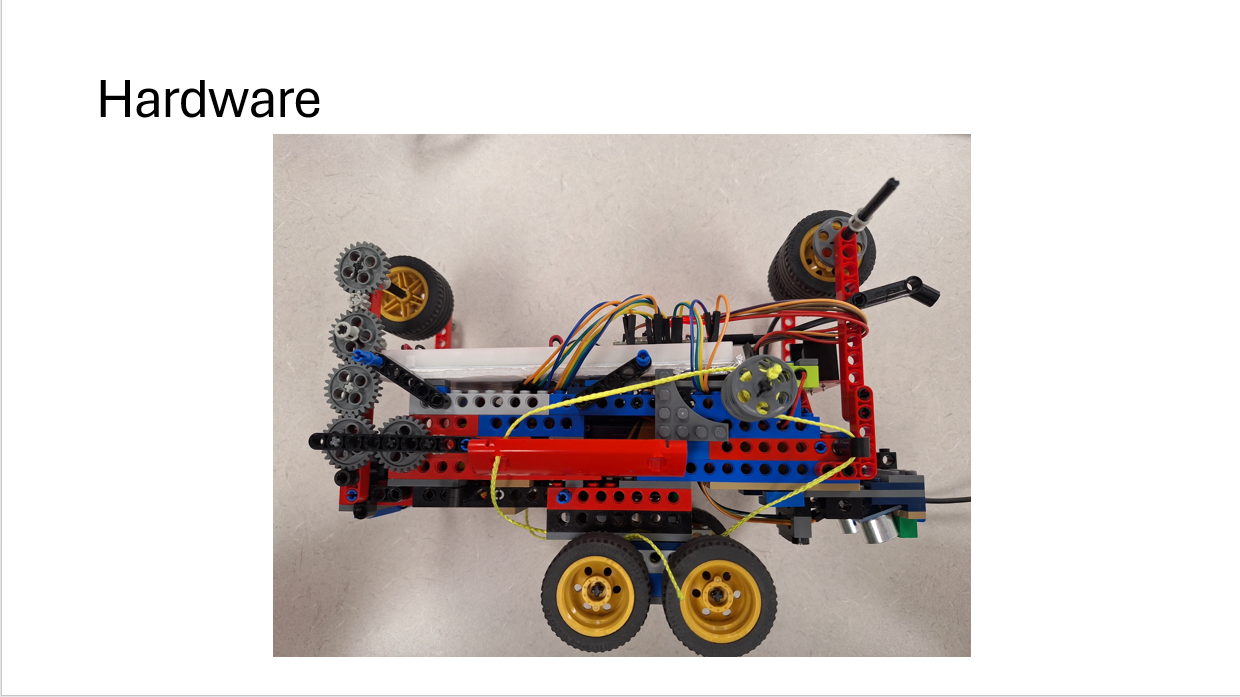

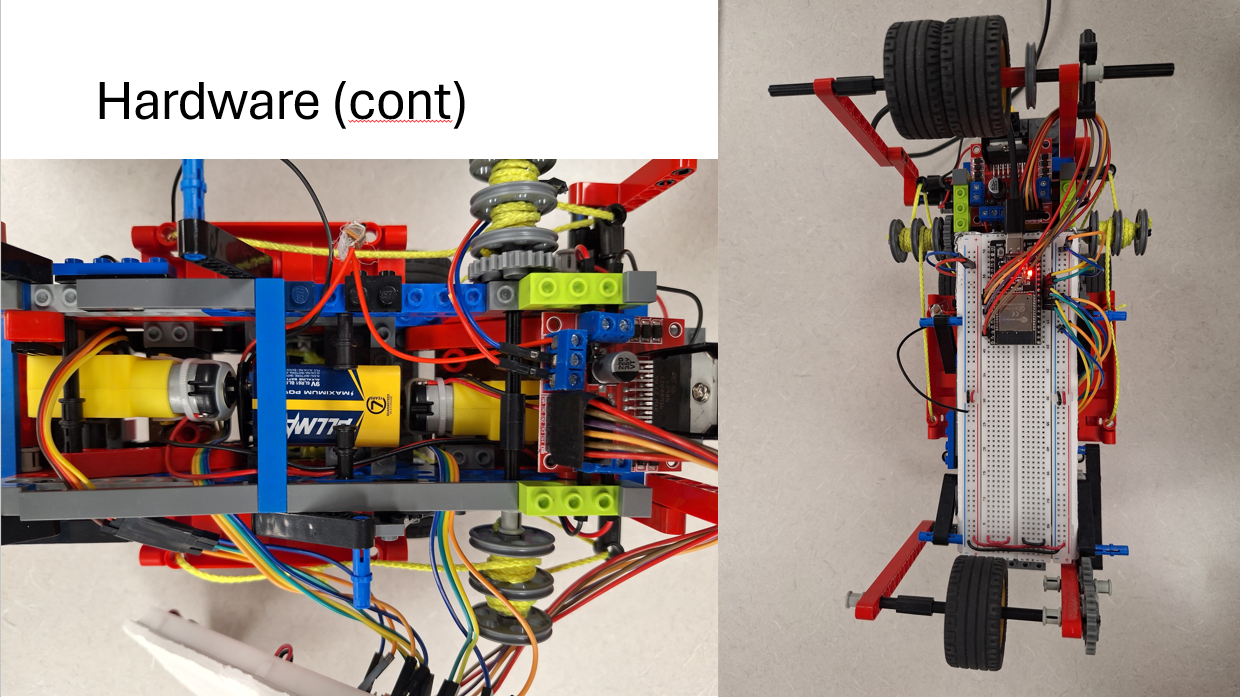